# Proyecto Series Temporales
### Grupo 8 - Walmart Sales
#### Integrantes:

- Diego Collado
- Iñigo Gonzalez-Varas
- Carlota Lopez
- Diego Lopez



Este trabajo trata de predecir las ventas semanales de Walmart.

Importamos las librerías necesarias para el trabajo.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import warnings
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression
from sklearn.tree import export_text
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from scipy import stats

warnings.filterwarnings('ignore')

## Exploración preliminar de los datos

In [2]:
train_set = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
test = pd.read_csv('test.csv')
features = pd.read_csv('features.csv')

Train set: 5 columnas
- Store: número de tienda
- Dept: número de departamento
- Date: fecha de inicio de la semana
- Weekly_Sales: ventas semanales (date->date+7)
- IsHoliday: si la semana contiene un dia festivo

In [3]:
train_set.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


Stores set: 3 columnas
- Store: número de tienda
- Type: tipo de tienda (se asigna una letra dependiendo del tamaño de la tienda)
- Size: tamaño de la tienda

In [4]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


Features set: 12 columnas
- Store: número de tienda
- Date: fecha de inicio de la semana
- Temperature: temperatura media durante la semana en la región donde está ubicada la tienda (Fahrenheit)
- Fuel_Price: precio medio del combustible en la zona donde está ubicada la tienda
- MarkDown1-5: datos anónimos relacionados con promociones. Esta información está disponible solo para algunas tiendas y para algunas fechas.
- CPI: índice de precios al consumo (Consumer Price Index). 
- Unemployment: tasa de desempleo
- IsHoliday: si la semana contiene un dia festivo


In [5]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


Test set: 4 columnas (subconjunto de train)
- Store: número de tienda
- Dept: número de departamento
- Date: fecha de inicio de la semana
- IsHoliday: si la semana contiene un dia festivo


In [6]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


## Conclusiones de la exploración preliminar

Con estos datos, vamos a tratar de predecir las ventas semanales de walmart agrupadas por tienda y departamento. 
En primer lugar, desarrollamos un modelo que únicamente tenga como input la serie temporal de ventas e intente prdecir las ventas futuras. 
Una vez veamos cómo funciona este modelo, añadiremos más variables (exógenas) para ver si podemos mejorar la predicción.

## Tratamiento de datos

En primer lugar, vamos a agrupar las ventas por tienda y departamento. Asignamos la fecha como índice del dataframe.

In [7]:
total_sales = train_set.groupby('Date')['Weekly_Sales'].sum().reset_index()
total_sales['Date'] = pd.to_datetime(total_sales['Date'], format='%Y-%m-%d')
total_sales = total_sales.set_index('Date')
total_sales = total_sales.asfreq('W-FRI')

total_sales

,Weekly_Sales
Date,
2010-02-05,49750740.50
2010-02-12,48336677.63
2010-02-19,48276993.78
2010-02-26,43968571.13
2010-03-05,46871470.30
...,...
2012-09-28,43734899.40
2012-10-05,47566639.31
2012-10-12,46128514.25


Observamos cómo queda la serie temporal de ventas semanales

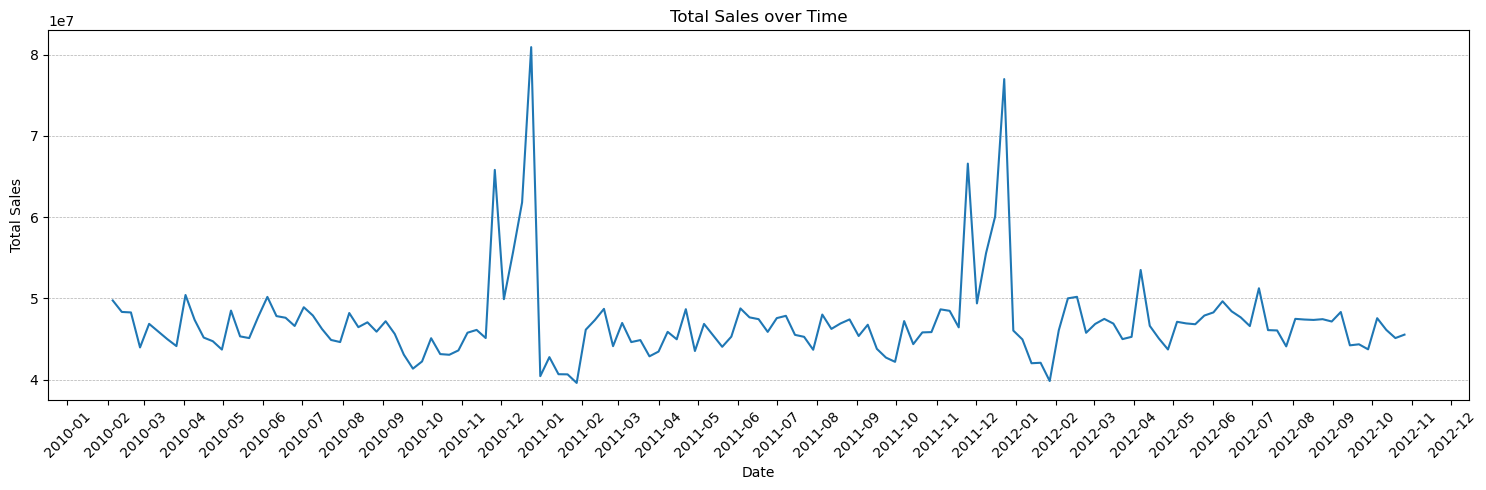

In [8]:
# Plotting the total sales over time
plt.figure(figsize=(15, 5))
plt.plot(total_sales.index, total_sales['Weekly_Sales'])
locator = mdates.MonthLocator()  
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Total Sales over Time')
plt.xticks(rotation=45)  # Rotate the x-ticks for better visibility
plt.tight_layout()  # Ensure layout is neat and no labels are cut off
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.show()

Vamos ver unas graficas para analizar las tendencias

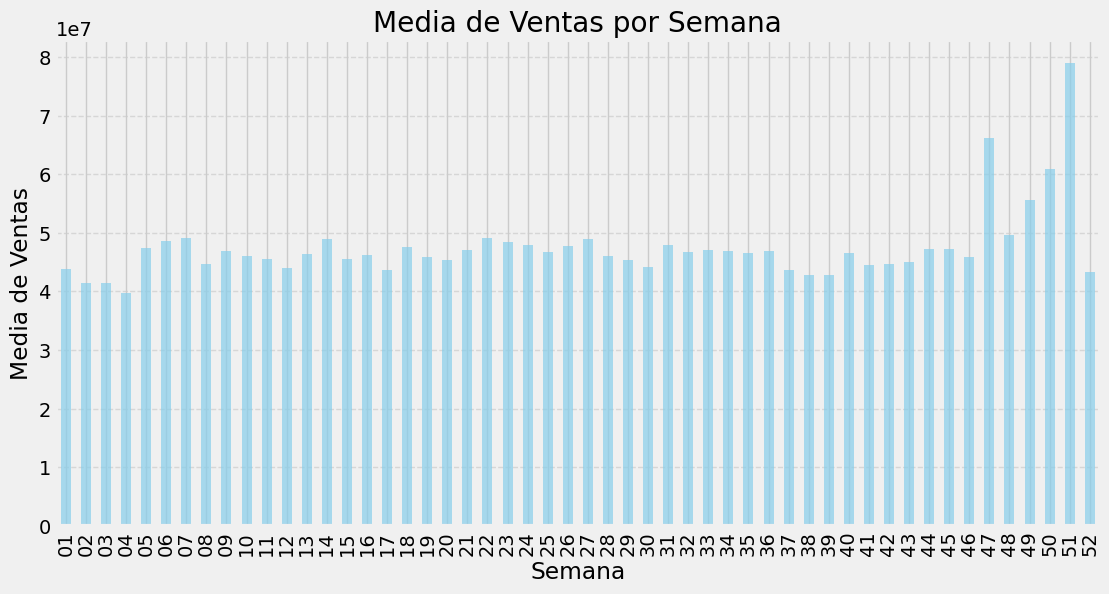

In [47]:
salesaux = total_sales.copy()
salesaux = salesaux.reset_index()
salesaux['Semana'] = salesaux['Date'].dt.strftime('%U')
semanas = salesaux.groupby('Semana')['Weekly_Sales'].mean()
# Crea una gráfica de barras para mostrar la media de ventas por semana
plt.figure(figsize=(12, 6))
semanas.plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Media de Ventas por Semana')
plt.xlabel('Semana')
plt.ylabel('Media de Ventas')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

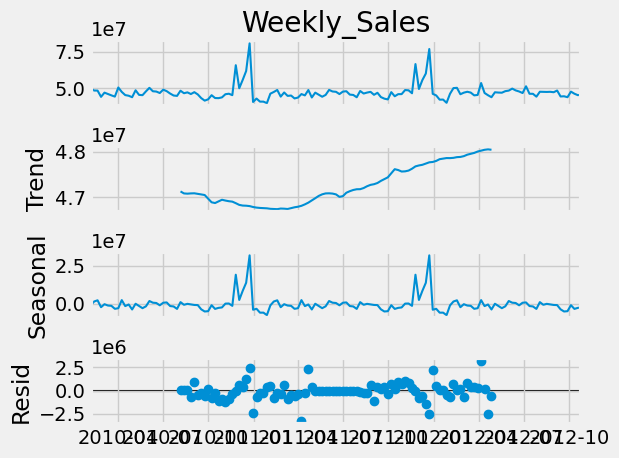

In [44]:
decomposition = sm.tsa.seasonal_decompose(total_sales['Weekly_Sales'], model = 'additive')
fig = decomposition.plot()

graficas acf y pcf

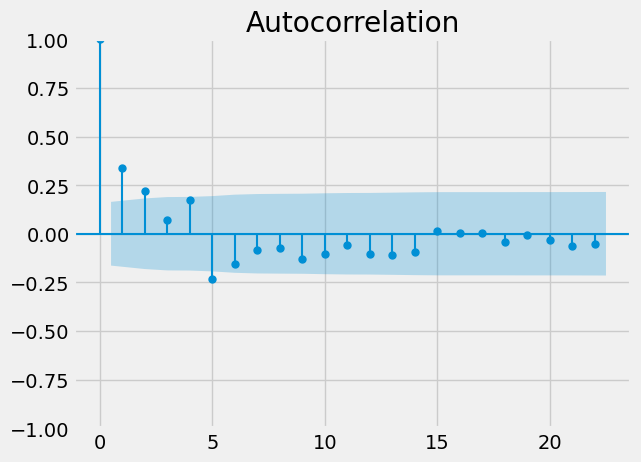

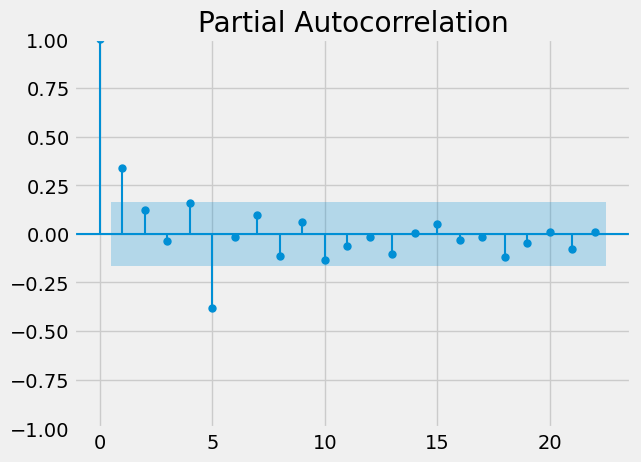

In [40]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(total_sales['Weekly_Sales']);

plot_pacf(total_sales['Weekly_Sales']);

Vamos a dividir la serie en train y test. Para ello, vamos a coger el 77% de los datos para train y el 23% para test. Se puede ver la división claramente en la gráfica

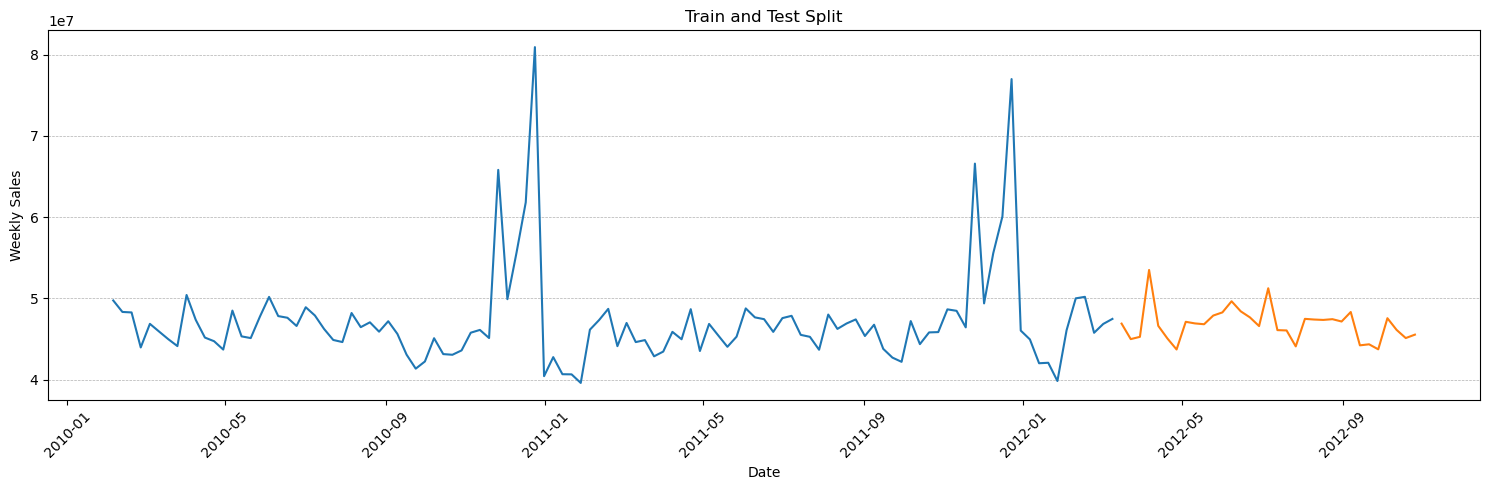

In [9]:
# splitting dataset into train and test set (80:20)
train, test = total_sales.iloc[:int(len(total_sales)*0.77)], total_sales.iloc[int(len(total_sales)*0.77):]
plt.figure(figsize=(15, 5))
plt.plot(train.index, train['Weekly_Sales'])
plt.plot(test.index, test['Weekly_Sales'])
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Train and Test Split')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.show()


Definimos una función para crear los lags de la serie temporal. Así, tendremos un dataset que pueda servir como input de un modelo. 

In [10]:
def create_lag_features(df, lag_columns, max_lag, max_yearly_lag=0):
    temp_df = df.copy()
    
    # Create weekly lag features
    for column in lag_columns:
        for lag in range(1, max_lag + 1):
            temp_df[f'{column}_lag_{lag}'] = temp_df[column].shift(lag)
    
    # Create yearly lag features for same week of previous years and the weeks before that
    for column in lag_columns:
        for year in range(1, max_yearly_lag + 1):
            for lag in range(0, max_lag):  # Starting from 0 to capture the same week from the previous year
                temp_df[f'{column}_year{year}_lag_{lag}'] = temp_df[column].shift(52 * year + lag)
                
    return temp_df

df = create_lag_features(total_sales, ['Weekly_Sales'], 15, max_yearly_lag=0)  # Adjust the parameters as needed
train, test = df.iloc[:int(len(df)*0.77)], df.iloc[int(len(df)*0.77):]
test.dropna(inplace=True)  # Drop the rows with missing values in the test set
train.dropna(inplace=True)
train.head()


,Weekly_Sales,Weekly_Sales_lag_1,Weekly_Sales_lag_2,Weekly_Sales_lag_3,Weekly_Sales_lag_4,Weekly_Sales_lag_5,Weekly_Sales_lag_6,Weekly_Sales_lag_7,Weekly_Sales_lag_8,Weekly_Sales_lag_9,Weekly_Sales_lag_10,Weekly_Sales_lag_11,Weekly_Sales_lag_12,Weekly_Sales_lag_13,Weekly_Sales_lag_14,Weekly_Sales_lag_15
Date,,,,,,,,,,,,,,,,
2010-05-21,45120108.06,45330080.20,48503243.52,43705126.71,44734452.56,45183667.08,47365290.44,50423831.26,44133961.05,44988974.64,45925396.51,46871470.30,43968571.13,48276993.78,48336677.63,49750740.50
2010-05-28,47757502.56,45120108.06,45330080.20,48503243.52,43705126.71,44734452.56,45183667.08,47365290.44,50423831.26,44133961.05,44988974.64,45925396.51,46871470.30,43968571.13,48276993.78,48336677.63
2010-06-04,50188543.12,47757502.56,45120108.06,45330080.20,48503243.52,43705126.71,44734452.56,45183667.08,47365290.44,50423831.26,44133961.05,44988974.64,45925396.51,46871470.30,43968571.13,48276993.78
2010-06-11,47826546.72,50188543.12,47757502.56,45120108.06,45330080.20,48503243.52,43705126.71,44734452.56,45183667.08,47365290.44,50423831.26,44133961.05,44988974.64,45925396.51,46871470.30,43968571.13
2010-06-18,47622046.23,47826546.72,50188543.12,47757502.56,45120108.06,45330080.20,48503243.52,43705126.71,44734452.56,45183667.08,47365290.44,50423831.26,44133961.05,44988974.64,45925396.51,46871470.30


## Entrenamiento del modelo

El primer modelo que vamos a entrenar es un Decision Tree Regressor, ya que fue el primer modelo utilizado en clase. Dividimos nuestros datos en de train y test en datos de entrada (X) y datos de salida (y). Definimos el modelo, lo entrenamos y hacemos la predicción.

### Decision Tree Regressor

In [11]:
X_train = train.drop('Weekly_Sales', axis=1)
y_train = train['Weekly_Sales']
X_test = test.drop('Weekly_Sales', axis=1)
y_test = test['Weekly_Sales']
# Crear y entrenar el modelo de árbol de decisión
modelo_arbol = DecisionTreeRegressor(max_depth=10, random_state=42)
modelo_arbol.fit(X_train, y_train)
predicciones_tree = modelo_arbol.predict(X_test)
err_tree = mean_squared_error(y_test, predicciones_tree)
err_mape =mean_absolute_percentage_error(y_test, predicciones_tree)
err_mae = mean_absolute_error(y_test, predicciones_tree)



Una vez predicho, comparamos los resultados con los datos de test. Para ello, creamos una gráfica con los datos de test y los datos predichos por el modelo.

ERR Tree: 9115231634551.14
ERR MAPE: 3.92% de error medio sobre las ventas semanales
ERR MAE: 1859727.58 ventas semanales de error medio


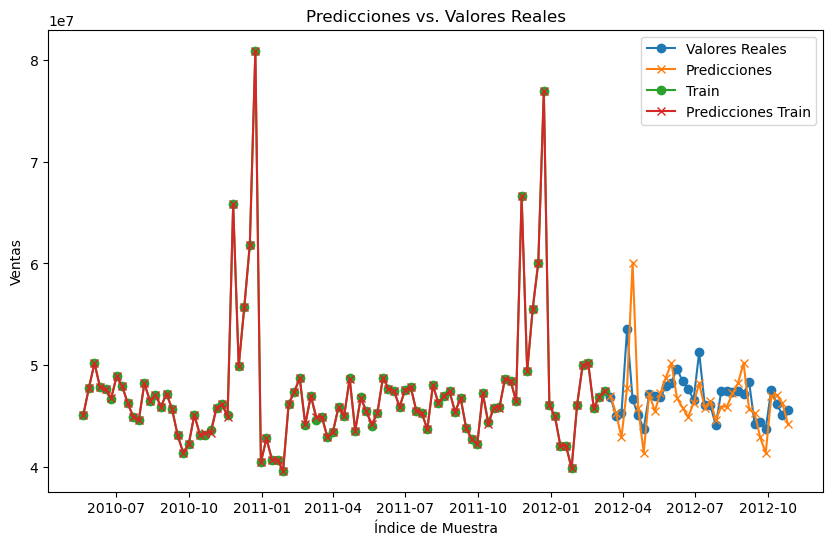

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index,y_test, label='Valores Reales', marker='o')
plt.plot(y_test.index,predicciones_tree, label='Predicciones', marker='x')
plt.plot(y_train.index,y_train, label='Train', marker='o')
plt.plot(y_train.index,modelo_arbol.predict(X_train), label='Predicciones Train', marker='x')
plt.xlabel('Índice de Muestra')
plt.ylabel('Ventas')
plt.title('Predicciones vs. Valores Reales')
err_tree = mean_squared_error(y_test, predicciones_tree)
err_mape =mean_absolute_percentage_error(y_test, predicciones_tree)
err_mae = mean_absolute_error(y_test, predicciones_tree)
print(f'ERR Tree: {err_tree:.2f}')
print(f'ERR MAPE: {err_mape * 100:.2f}% de error medio sobre las ventas semanales')
print(f'ERR MAE: {err_mae:.2f} ventas semanales de error medio')
plt.legend()
plt.show()

### LINEAR REGRESSION


El segundo modelo que vamos a entrenar es un Forecaster de skforecast que utilice regresión lineal y 15 lags. Después de entrenarlo, hacemos la predicción y comparamos los resultados con los datos de test.

In [13]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags = 15
             )

forecaster.fit(y=train['Weekly_Sales'])

# Intervalos de predicción
# ==============================================================================
predicciones = forecaster.predict_interval(
                    steps    = len(y_test)
               )
predicciones = predicciones.set_index(y_test.index)
predicciones.head(5)

err_mse = mean_squared_error(y_test, predicciones['pred'])
err_mape =mean_absolute_percentage_error(y_test, predicciones['pred'])
err_mae = mean_absolute_error(y_test, predicciones['pred'])


Hacemos una gráfica con los valores reales y los predichos, así como los intervalos de confianza.

ERR MSE: 7094968542336.75
ERR MAPE: 4.16% de error medio sobre las ventas semanales
ERR MAE: 1932582.18 ventas semanales de error medio


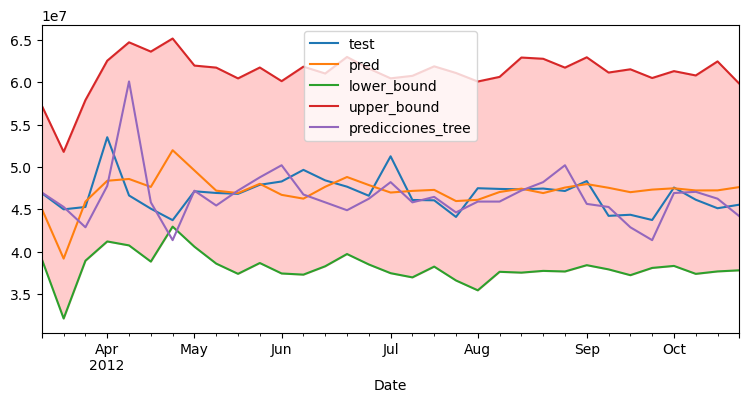

In [14]:
fig, ax = plt.subplots(figsize=(9, 4))
y_test.plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
predicciones_tree = pd.Series(predicciones_tree, index=y_test.index)
predicciones_tree.plot(ax=ax, label='predicciones_tree')
ax.fill_between(
    y_test.index,
    predicciones['lower_bound'],
    predicciones['upper_bound'],
    color = 'red',
    alpha = 0.2
)
print(f'ERR MSE: {err_mse:.2f}')
print(f'ERR MAPE: {err_mape * 100:.2f}% de error medio sobre las ventas semanales')
print(f'ERR MAE: {err_mae:.2f} ventas semanales de error medio')
ax.legend();

## SARIMAX

In [53]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
order = (2, 1, 1) 
# el primer componente es el orden de autorregresión (número de términos autorregresivos en el modelo)
# el segundo componente es el orden de diferenciación (cuántas veces se diferencia la serie temporal para hacerla estacionaria)
# el tercer componente es el orden de media móvil (número de términos de media móvil en el modelo)

seasonal_order = (2, 1, 1, 52)
# el primer componente es el orden de autorregresión estacional (número de términos autorregresivos estacionales en el modelo)
# el segundo componente es el orden de diferenciación estacional (cuántas veces se diferencia la serie temporal para hacerla estacionaria)
# el tercer componente es el orden de media móvil estacional (número de términos de media móvil estacional en el modelo)
# el cuarto componente es la periodicidad estacional (cuántos períodos de tiempo hay en una temporada)

# Build and fit the SARIMAX
train, test = total_sales.iloc[:int(len(total_sales)*0.77)], total_sales.iloc[int(len(total_sales)*0.77):]
model = SARIMAX(endog = train, order = order, seasonal_order = seasonal_order)
results = model.fit() 
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  110
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 52)   Log Likelihood                -903.578
Date:                            Sun, 08 Oct 2023   AIC                           1821.156
Time:                                    18:31:09   BIC                           1835.458
Sample:                                02-05-2010   HQIC                          1826.714
                                     - 03-09-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1052      2.753     -0.038      0.970      -5.501       5.291
ar.L2         -0.0393      0.279   

FORECASTER: 5
ERR MSE: 4301741459013.4639
ERR MAPE: 3.5685% de error medio sobre las ventas semanales
ERR MAE: 1667745.6677 ventas semanales de error medio


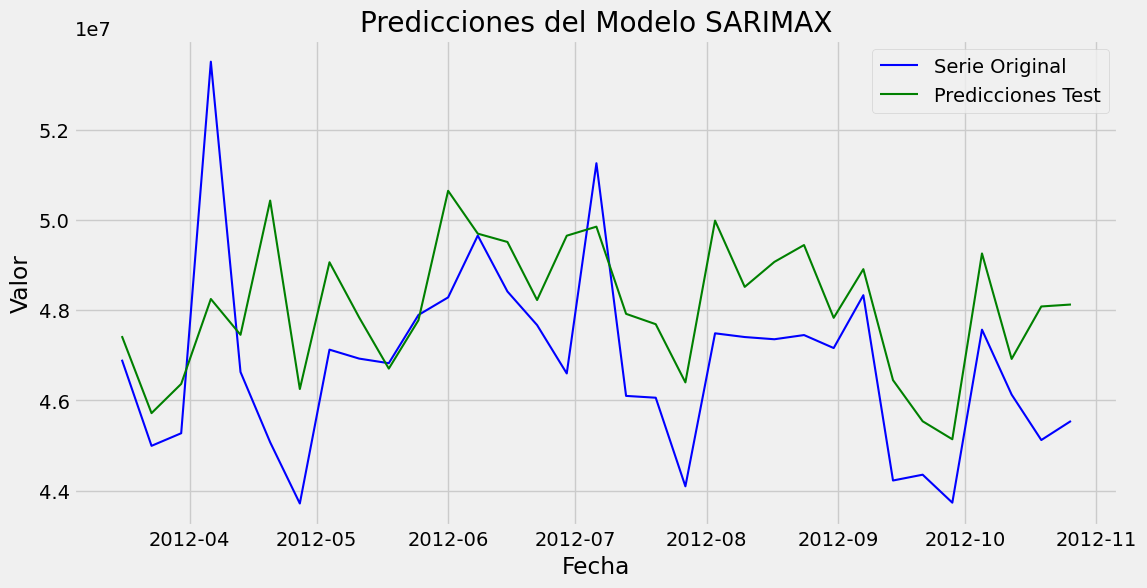

In [55]:
predicciones_test = results.get_prediction(start = len(train), end = len(train) + len(test) - 1)
predicciones_test_valores = predicciones_test.predicted_mean
plt.figure(figsize=(12, 6))
plt.plot(test, label='Serie Original', color='blue')
plt.plot(predicciones_test_valores.index, predicciones_test_valores, label='Predicciones Test', color='green')
plt.legend()
plt.title('Predicciones del Modelo SARIMAX')
plt.xlabel('Fecha')
plt.ylabel('Valor')
err_mse = mean_squared_error(test, predicciones_test_valores)
err_mape = mean_absolute_percentage_error(test, predicciones_test_valores)
err_mae = mean_absolute_error(test, predicciones_test_valores)
print(f'FORECASTER: {i+1}')
print(f'ERR MSE: {err_mse:.4f}')
print(f'ERR MAPE: {err_mape * 100:.4f}% de error medio sobre las ventas semanales')
print(f'ERR MAE: {err_mae:.4f} ventas semanales de error medio')
plt.show()

# EXPERIMENTO 2

Una vez vistos los dos primeros modelos mas basicos vamos a profundizar un poco mas para imtentar mejorar los resultados

In [15]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

## BUCLE 0

In [16]:
regressors = [
    Lasso,
    RandomForestRegressor,
    KNeighborsRegressor,
]

best_regressors = []




steps = len(y_test)

for regressor in regressors:
    
        forecaster = ForecasterAutoreg(
            regressor=regressor(),
            lags = 6
        )
        
        
        forecaster.fit(y=train['Weekly_Sales'])
        # Fit using the best parameters from the grid search
        best_forecaster = forecaster
        
        predicciones = best_forecaster.predict(steps=len(y_test))
        err = mean_squared_error(y_test, predicciones)
        
        best_regressors.append({
            'forecaster': best_forecaster,
            'regressor': regressor,
            'err': err
        })

FORECASTER: 1
ERR MSE: 4294663927332.4839
ERR MAPE: 3.1573% de error medio sobre las ventas semanales
ERR MAE: 1476670.0718 ventas semanales de error medio
FORECASTER: 2
ERR MSE: 4500938319757.7090
ERR MAPE: 3.1218% de error medio sobre las ventas semanales
ERR MAE: 1501681.7866 ventas semanales de error medio
FORECASTER: 3
ERR MSE: 10436804641311.6523
ERR MAPE: 4.9656% de error medio sobre las ventas semanales
ERR MAE: 2343660.6324 ventas semanales de error medio


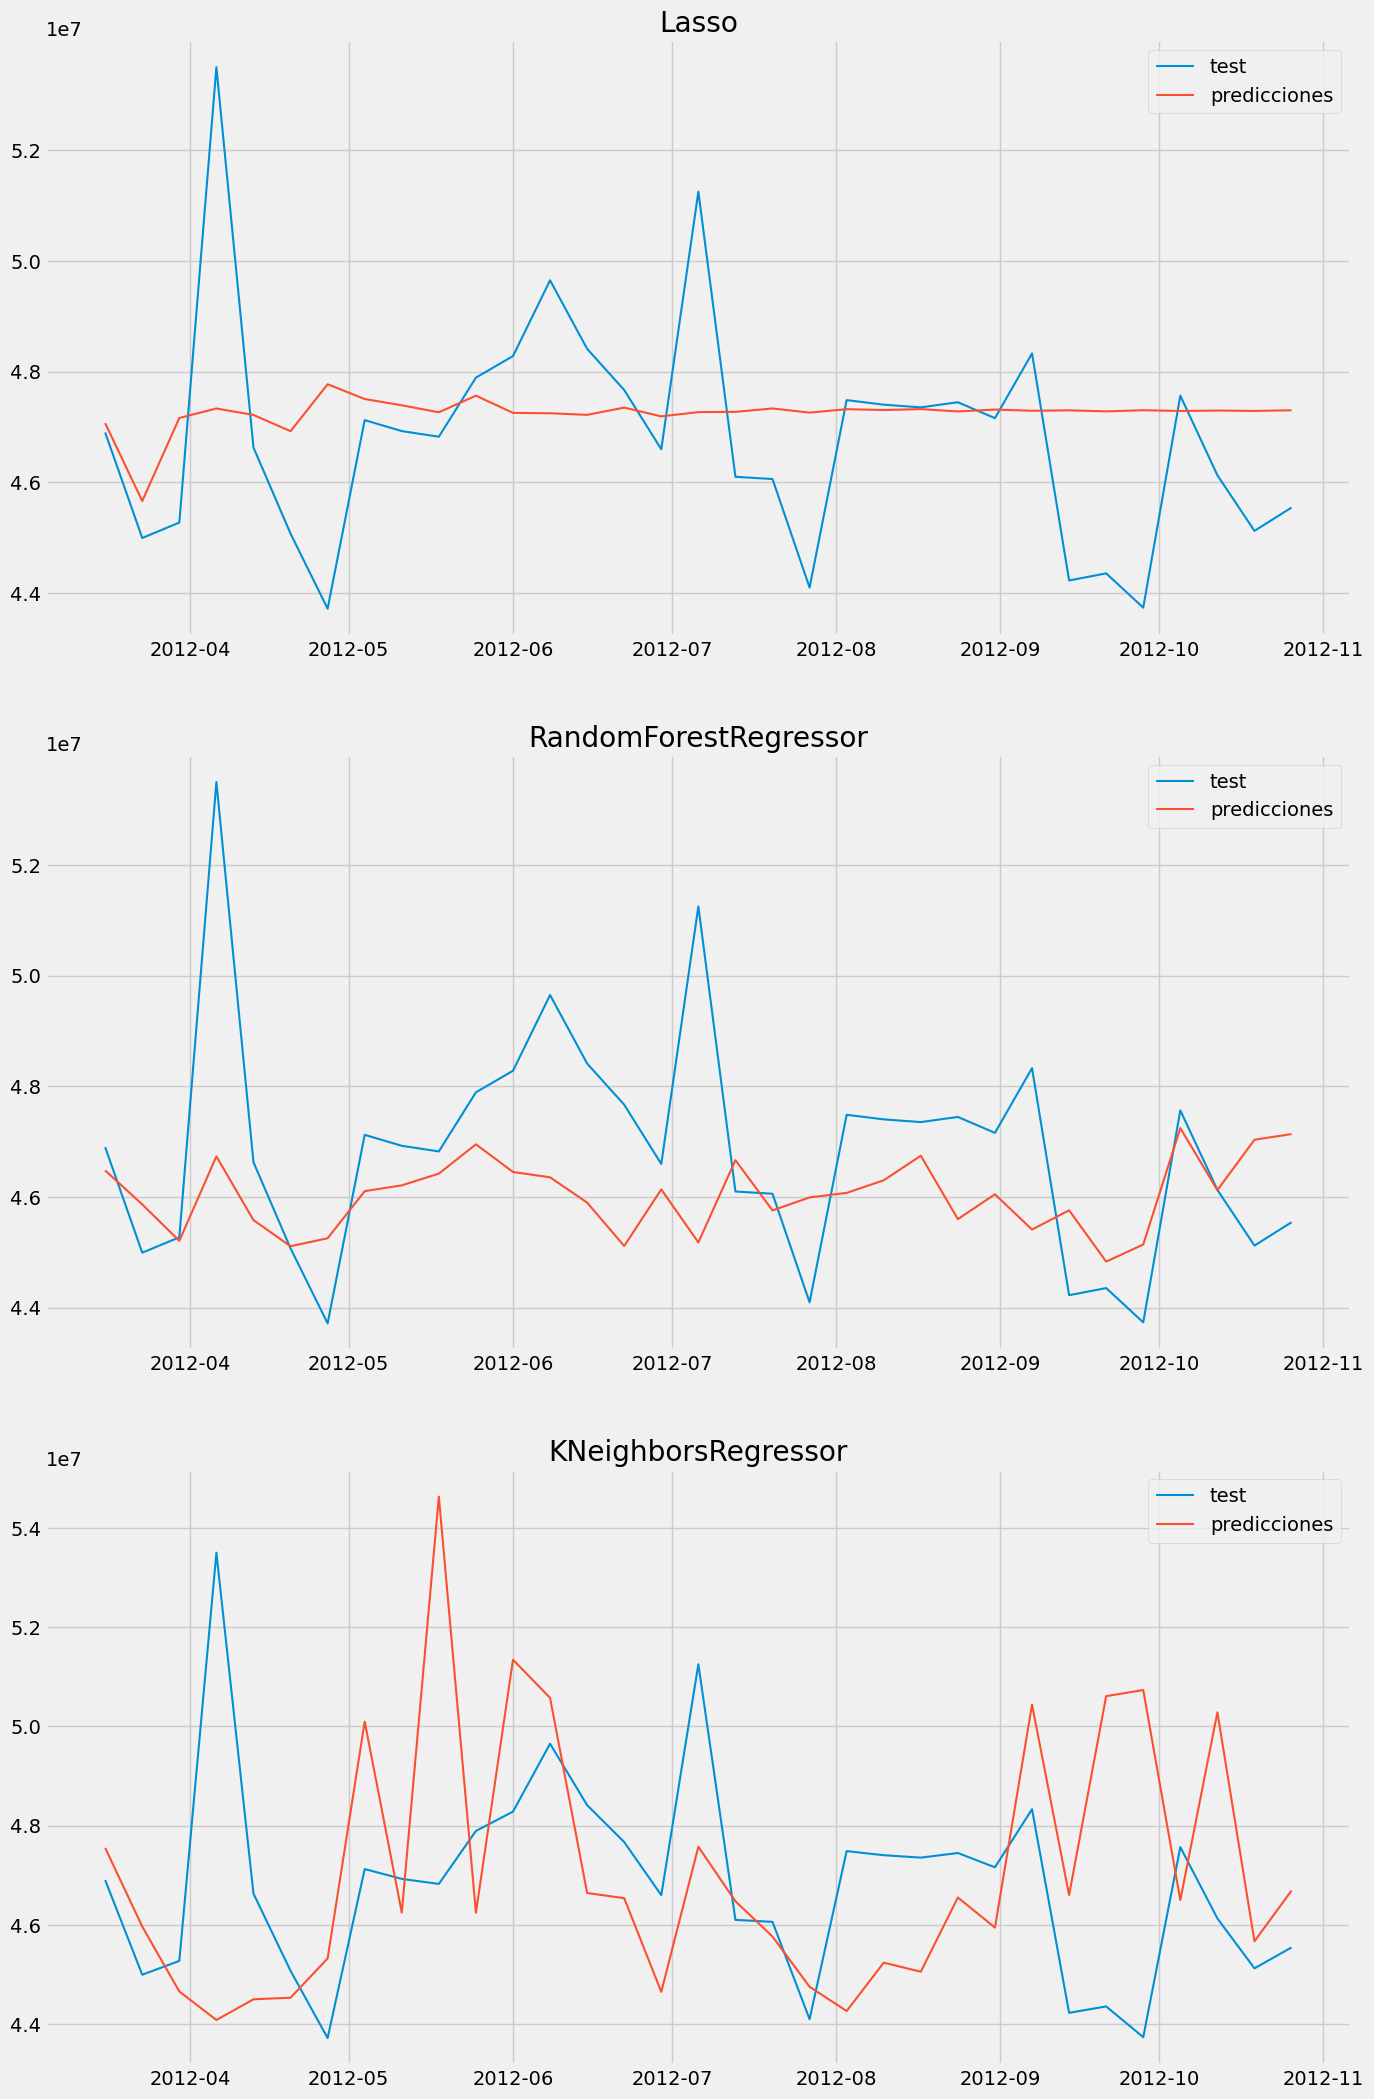

In [17]:
best_regressors = pd.DataFrame(best_regressors)
best_regressors.sort_values('err')

fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(15, 5*5))

for i, row in best_regressors.iterrows():
    #predict and plot predictions
    predicciones = row['forecaster'].predict(steps=len(y_test))
    err_mse = mean_squared_error(y_test, predicciones)
    err_mape = mean_absolute_percentage_error(y_test, predicciones)
    err_mae = mean_absolute_error(y_test, predicciones)
    print(f'FORECASTER: {i+1}')
    print(f'ERR MSE: {err_mse:.4f}')
    print(f'ERR MAPE: {err_mape * 100:.4f}% de error medio sobre las ventas semanales')
    print(f'ERR MAE: {err_mae:.4f} ventas semanales de error medio')

    ax[i].plot(y_test.index, y_test, label='test')
    ax[i].plot(y_test.index, predicciones, label='predicciones')
    ax[i].set_title(row['regressor'].__name__)
    ax[i].legend();

## BUCLE 1

In [18]:
regressors = [
    LinearRegression,
    Lasso,
    DecisionTreeRegressor,
    RandomForestRegressor,
    KNeighborsRegressor,
]

best_regressors = []

# Placeholder for param_grid, lags_grid, and steps. Please provide appropriate values
param_grid = {
    LinearRegression: {
        'fit_intercept': [True, False],
    },
    Lasso: {
        'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
        'fit_intercept': [True, False],
    },
    DecisionTreeRegressor: {
        'max_depth': [None, 10, 20, 30, 40, 50, 100, 200],
    },
    RandomForestRegressor: {
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [None, 10, 20, 30, 40, 50, 100, 200],

        
    },
    KNeighborsRegressor: {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }
}

lags_grid = list(range(1, 30))

steps = len(y_test)

for regressor in regressors:
    
        forecaster = ForecasterAutoreg(
            regressor=regressor(),
            lags = lags_grid[0]
        )
        
        current_param_grid = param_grid[regressor]

        resultados_grid = grid_search_forecaster(
            forecaster=forecaster,
            y=train['Weekly_Sales'],
            
            param_grid=current_param_grid,
            lags_grid=lags_grid,
            steps=steps,
            refit=True,
            metric='mean_squared_error',
            initial_train_size=int(len(train) * 0.5),
            fixed_train_size=False,
            return_best=True,
            verbose=False
        )

        # Fit using the best parameters from the grid search
        best_forecaster = forecaster
        
        predicciones = best_forecaster.predict(steps=len(y_test))
        err = mean_squared_error(y_test, predicciones)
        
        best_regressors.append({
            'forecaster': best_forecaster,
            'regressor': regressor,
            'lags': resultados_grid['lags'],
            'err': err
        })

Number of models compared: 58.


lags grid:   0%|          | 0/29 [00:00<?, ?it/s]

params grid:   0%|          | 0/2 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'fit_intercept': True}
  Backtesting metric: 28539536633010.312

Number of models compared: 348.


lags grid:   0%|          | 0/29 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'alpha': 0.001, 'fit_intercept': True}
  Backtesting metric: 28539536633010.27

Number of models compared: 232.


lags grid:   0%|          | 0/29 [00:00<?, ?it/s]

params grid:   0%|          | 0/8 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1] 
  Parameters: {'max_depth': 10}
  Backtesting metric: 12929550841459.568

Number of models compared: 928.


lags grid:   0%|          | 0/29 [00:00<?, ?it/s]

params grid:   0%|          | 0/32 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7 8 9] 
  Parameters: {'max_depth': 40, 'n_estimators': 10}
  Backtesting metric: 18883022188734.785

Number of models compared: 1160.


lags grid:   0%|          | 0/29 [00:00<?, ?it/s]

params grid:   0%|          | 0/40 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7 8] 
  Parameters: {'algorithm': 'brute', 'n_neighbors': 3, 'weights': 'distance'}
  Backtesting metric: 16423313110841.365



FORECASTER: 1
ERR MSE: 4266729108221.9619
ERR MAPE: 3.1316% de error medio sobre las ventas semanales
ERR MAE: 1465361.0438 ventas semanales de error medio
FORECASTER: 2
ERR MSE: 4266729108221.9688
ERR MAPE: 3.1316% de error medio sobre las ventas semanales
ERR MAE: 1465361.0438 ventas semanales de error medio
FORECASTER: 3
ERR MSE: 6333237886130.2139
ERR MAPE: 4.0351% de error medio sobre las ventas semanales
ERR MAE: 1875851.3438 ventas semanales de error medio
FORECASTER: 4
ERR MSE: 37624150195121.4766
ERR MAPE: 10.6382% de error medio sobre las ventas semanales
ERR MAE: 4911131.5997 ventas semanales de error medio
FORECASTER: 5
ERR MSE: 10641285279747.5918
ERR MAPE: 5.4561% de error medio sobre las ventas semanales
ERR MAE: 2583808.9567 ventas semanales de error medio


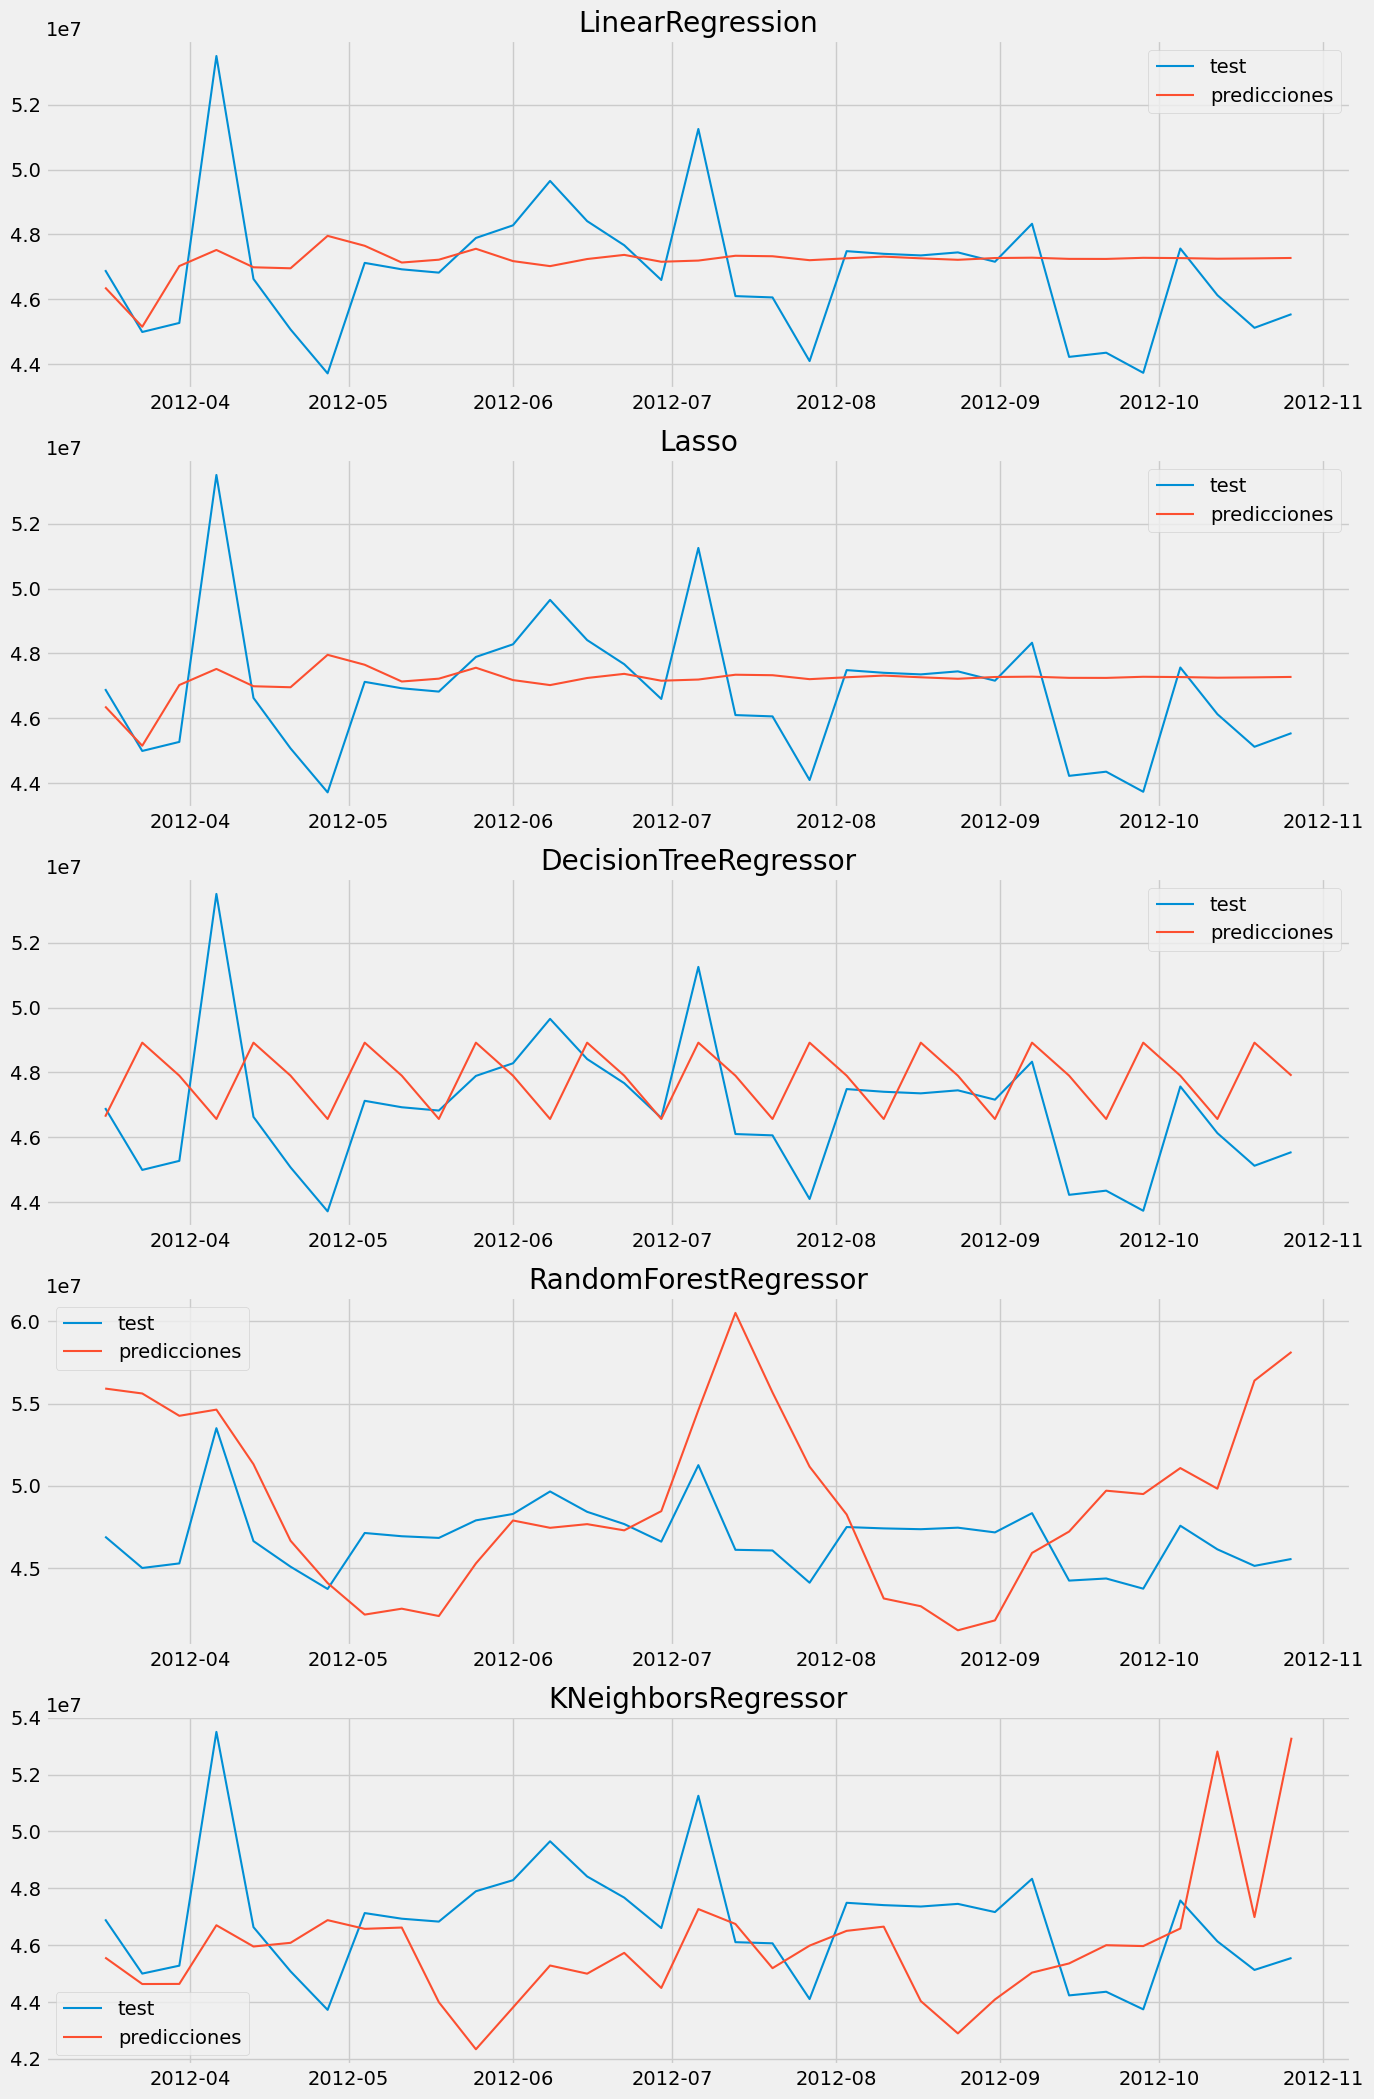

In [19]:
best_regressors = pd.DataFrame(best_regressors)
best_regressors.sort_values('err')

fig, ax = plt.subplots(ncols=1, nrows=5, figsize=(15, 5*5))

for i, row in best_regressors.iterrows():
    #predict and plot predictions
    predicciones = row['forecaster'].predict(steps=len(y_test))
    err_mse = mean_squared_error(y_test, predicciones)
    err_mape = mean_absolute_percentage_error(y_test, predicciones)
    err_mae = mean_absolute_error(y_test, predicciones)
    print(f'FORECASTER: {i+1}')
    print(f'ERR MSE: {err_mse:.4f}')
    print(f'ERR MAPE: {err_mape * 100:.4f}% de error medio sobre las ventas semanales')
    print(f'ERR MAE: {err_mae:.4f} ventas semanales de error medio')

    ax[i].plot(y_test.index, y_test, label='test')
    ax[i].plot(y_test.index, predicciones, label='predicciones')
    ax[i].set_title(row['regressor'].__name__)
    ax[i].legend();

## VARIABLES EXOGENAS

## BUCLE

In [20]:
df = train_set.merge(features, on=['Store', 'Date'], how='inner').merge(stores, on=['Store'], how='inner')
df.drop(['IsHoliday_y'], axis=1,inplace=True) 
df.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True)
df.loc[df['Weekly_Sales']<=0]
df = df.loc[df['Weekly_Sales'] > 0]
df = df.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','Size','Type'], axis=1)
df_agrupado = df.groupby('Date').agg({'Weekly_Sales': 'sum'}).reset_index()
df_agrupado = df_agrupado.merge(df.drop('Weekly_Sales', axis=1), on=['Date'], how='inner')
df_agrupado.drop('Dept', axis=1, inplace=True)
df_agrupado.drop('Store', axis=1, inplace=True)
df_sin_duplicados = df_agrupado.drop_duplicates(subset=['Weekly_Sales'])
df_sin_duplicados =df_sin_duplicados.reset_index(drop=  True)
df_sin_duplicados

,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment
0,2010-02-05,49750875.98,False,42.31,2.572,211.096358,8.106
1,2010-02-12,48336800.10,True,38.51,2.548,211.242170,8.106
2,2010-02-19,48277902.33,False,39.93,2.514,211.289143,8.106
3,2010-02-26,43970440.65,False,46.63,2.561,211.319643,8.106
4,2010-03-05,46872715.16,False,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...
138,2012-09-28,43735713.56,False,76.08,3.666,222.981658,6.908
139,2012-10-05,47567053.49,False,68.55,3.617,223.181477,6.573
140,2012-10-12,46128909.98,False,62.99,3.601,223.381296,6.573
141,2012-10-19,45122443.96,False,67.97,3.594,223.425723,6.573


In [21]:
df_sin_duplicados['Date'] = pd.to_datetime(df_sin_duplicados['Date'], format='%Y-%m-%d')
df_sin_duplicados = df_sin_duplicados.set_index('Date')
df_sin_duplicados = df_sin_duplicados.asfreq('W-FRI')

In [22]:
dfexog = df_sin_duplicados.copy()
dfexog['IsHoliday'] = dfexog['IsHoliday'].astype(int)
dfexog

,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,
2010-02-05,49750875.98,0,42.31,2.572,211.096358,8.106
2010-02-12,48336800.10,1,38.51,2.548,211.242170,8.106
2010-02-19,48277902.33,0,39.93,2.514,211.289143,8.106
2010-02-26,43970440.65,0,46.63,2.561,211.319643,8.106
2010-03-05,46872715.16,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...
2012-09-28,43735713.56,0,76.08,3.666,222.981658,6.908
2012-10-05,47567053.49,0,68.55,3.617,223.181477,6.573
2012-10-12,46128909.98,0,62.99,3.601,223.381296,6.573


In [23]:
steps = len(y_test)
datos_train = dfexog[:-steps]
datos_test  = dfexog[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train : 2010-02-05 00:00:00 --- 2012-03-09 00:00:00  (n=110)
Fechas test  : 2012-03-16 00:00:00 --- 2012-10-26 00:00:00  (n=33)


In [25]:
regressors = [
    LinearRegression,
    Lasso,
    DecisionTreeRegressor,
    RandomForestRegressor,
    KNeighborsRegressor,
]

best_regressors = []

# Placeholder for param_grid, lags_grid, and steps. Please provide appropriate values
param_grid = {
    LinearRegression: {
        'fit_intercept': [True, False],
    },
    Lasso: {
        'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
        'fit_intercept': [True, False],
    },
    DecisionTreeRegressor: {
        'max_depth': [None, 10, 20, 30, 40, 50, 100, 200],
    },
    RandomForestRegressor: {
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [None, 10, 20, 30, 40, 50, 100, 200],

        
    },
    KNeighborsRegressor: {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }
}

lags_grid = list(range(1, 30))

steps = len(datos_test)

for regressor in regressors:
    
        forecaster = ForecasterAutoreg(
            regressor=regressor(),
            lags = lags_grid[0]
        )
        
        current_param_grid = param_grid[regressor]

        resultados_grid = grid_search_forecaster(
            forecaster=forecaster,
            y=datos_train['Weekly_Sales'],
            exog=datos_train.drop(columns='Weekly_Sales'),
            param_grid=current_param_grid,
            lags_grid=lags_grid,
            steps=steps,
            refit=True,
            metric='mean_squared_error',
            initial_train_size=int(len(datos_train) * 0.5),
            fixed_train_size=False,
            return_best=True,
            verbose=False
        )

        # Fit using the best parameters from the grid search
        best_forecaster = forecaster
        
        predicciones = best_forecaster.predict(steps=len(datos_test), exog=datos_test.drop(columns='Weekly_Sales'))
        err = mean_squared_error(datos_test['Weekly_Sales'], predicciones)
        
        best_regressors.append({
            'forecaster': best_forecaster,
            'regressor': regressor,
            'lags': resultados_grid['lags'],
            'err': err
        })

Number of models compared: 58.


lags grid:   0%|          | 0/29 [00:00<?, ?it/s]

params grid:   0%|          | 0/2 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4] 
  Parameters: {'fit_intercept': False}
  Backtesting metric: 31178026012456.09

Number of models compared: 348.


lags grid:   0%|          | 0/29 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4] 
  Parameters: {'alpha': 100, 'fit_intercept': False}
  Backtesting metric: 47162341217464.2

Number of models compared: 232.


lags grid:   0%|          | 0/29 [00:00<?, ?it/s]

params grid:   0%|          | 0/8 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'max_depth': None}
  Backtesting metric: 6920174567404.685

Number of models compared: 928.


lags grid:   0%|          | 0/29 [00:00<?, ?it/s]

params grid:   0%|          | 0/32 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4] 
  Parameters: {'max_depth': 10, 'n_estimators': 10}
  Backtesting metric: 22042137777073.105

Number of models compared: 1160.


lags grid:   0%|          | 0/29 [00:00<?, ?it/s]

params grid:   0%|          | 0/40 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] 
  Parameters: {'algorithm': 'brute', 'n_neighbors': 3, 'weights': 'distance'}
  Backtesting metric: 29113756968409.934



FORECASTER: 1
ERR MSE: 14653903767904.3965
ERR MAPE: 6.7703% de error medio sobre las ventas semanales
ERR MAE: 3240013.7034 ventas semanales de error medio
FORECASTER: 2
ERR MSE: 5505305543352.1826
ERR MAPE: 3.7421% de error medio sobre las ventas semanales
ERR MAE: 1798154.6377 ventas semanales de error medio
FORECASTER: 3
ERR MSE: 14805254502968.8027
ERR MAPE: 4.7751% de error medio sobre las ventas semanales
ERR MAE: 2236379.1033 ventas semanales de error medio
FORECASTER: 4
ERR MSE: 7445812258900.8340
ERR MAPE: 3.9910% de error medio sobre las ventas semanales
ERR MAE: 1888421.6160 ventas semanales de error medio
FORECASTER: 5
ERR MSE: 6398286205562.8652
ERR MAPE: 4.0364% de error medio sobre las ventas semanales
ERR MAE: 1916384.9572 ventas semanales de error medio


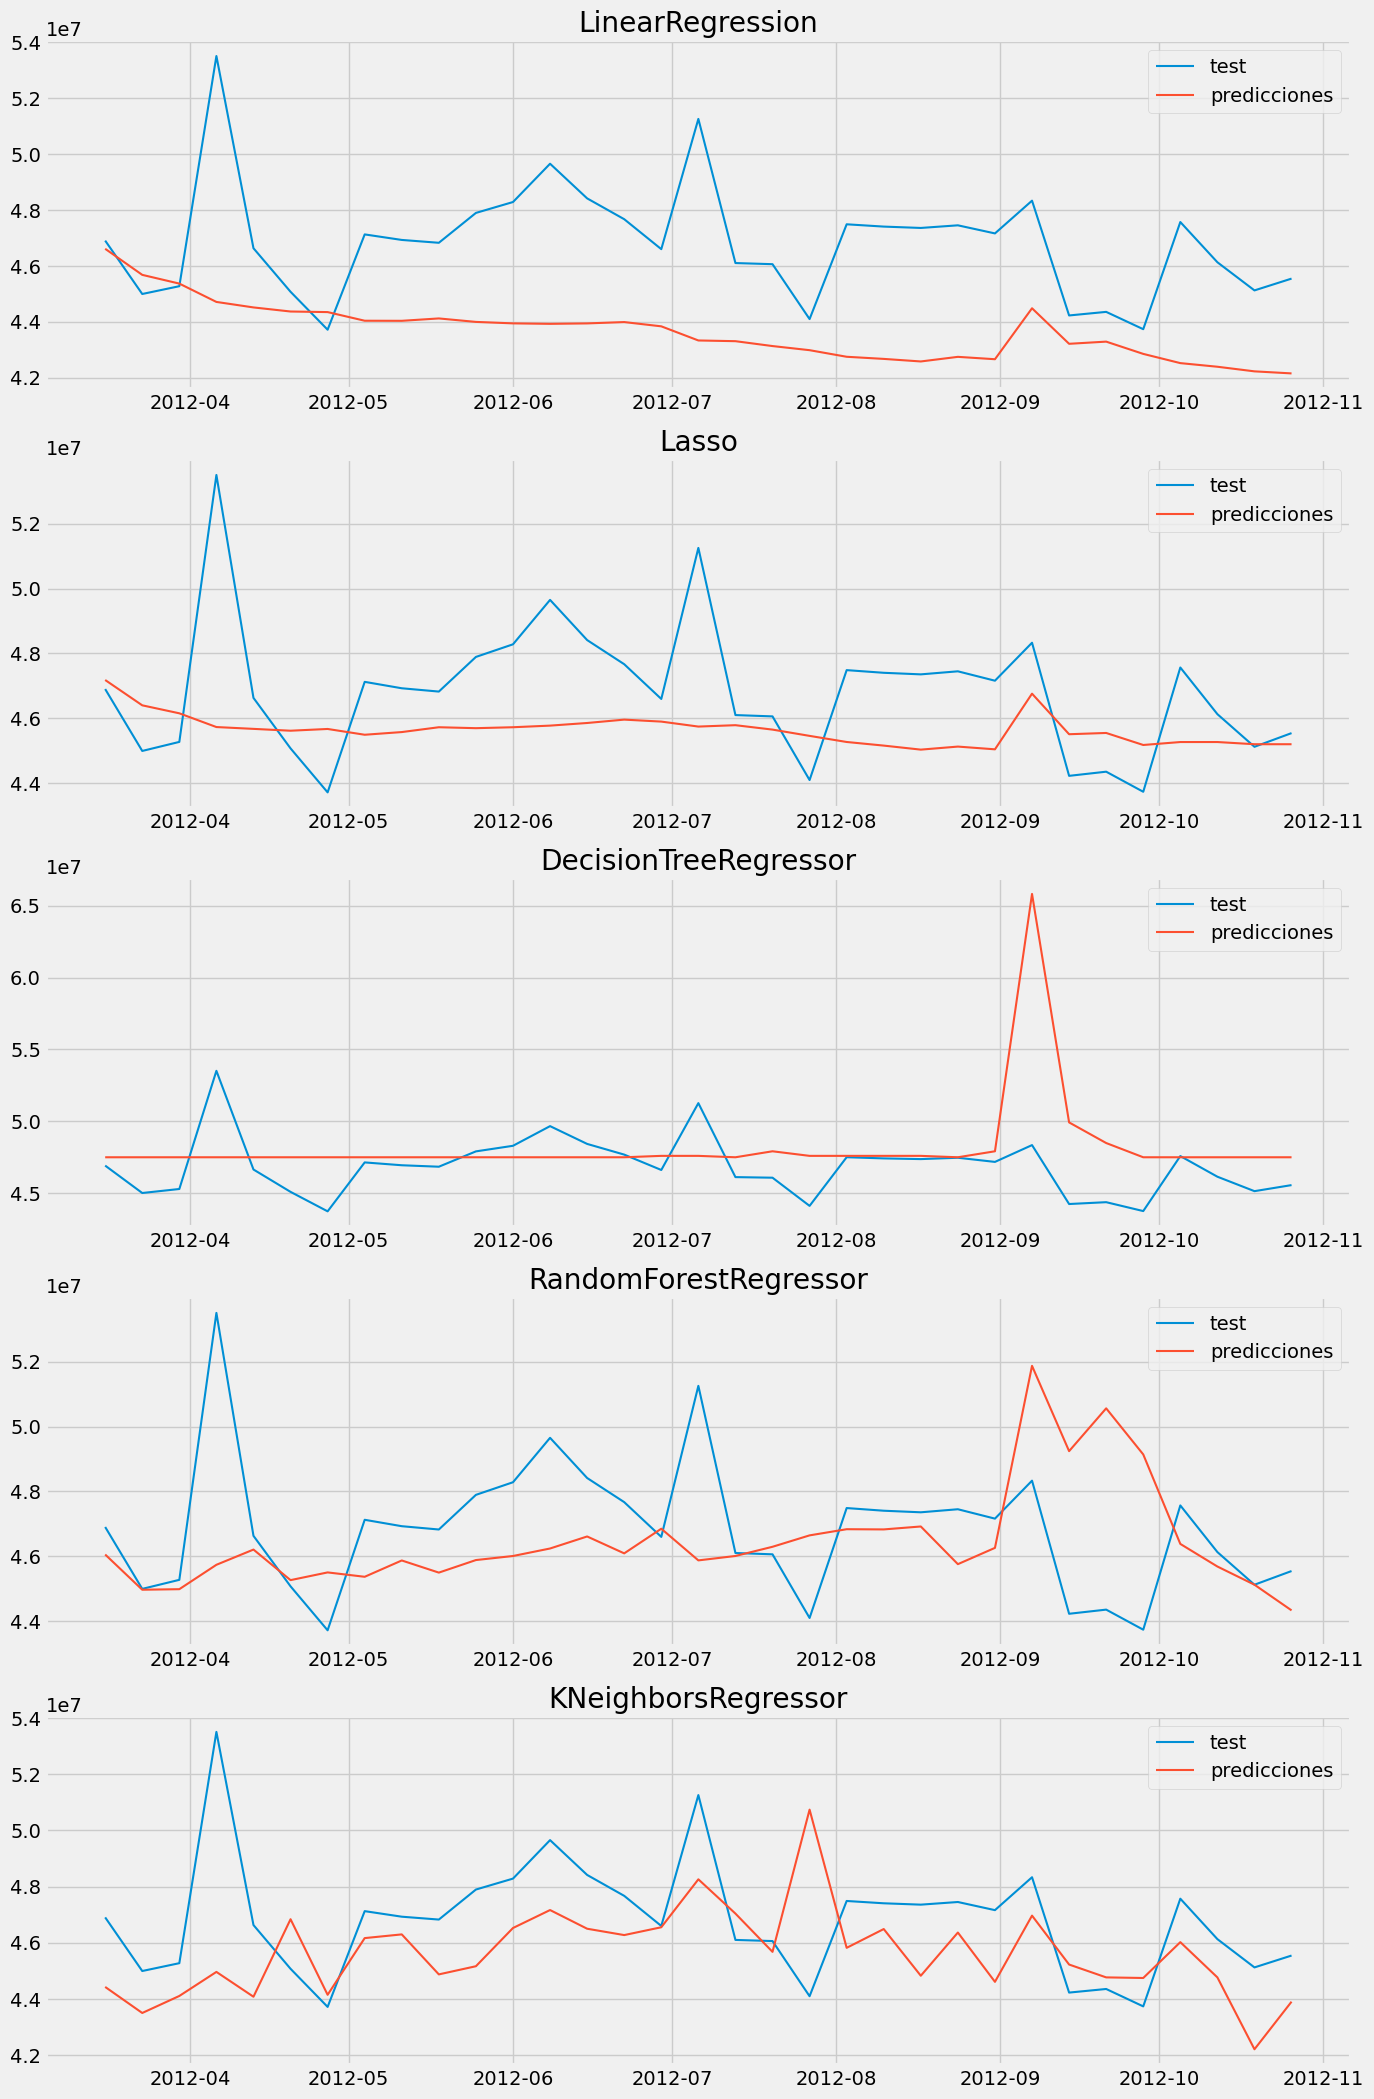

In [ ]:
best_regressors = pd.DataFrame(best_regressors)
best_regressors.sort_values('err')

fig, ax = plt.subplots(ncols=1, nrows=5, figsize=(15, 5*5))

for i, row in best_regressors.iterrows():
    #predict and plot predictions
    predicciones = row['forecaster'].predict(steps=len(datos_test), exog=datos_test.drop(columns='Weekly_Sales'))
    err_mse = mean_squared_error(datos_test['Weekly_Sales'], predicciones)
    err_mape = mean_absolute_percentage_error(datos_test['Weekly_Sales'], predicciones)
    err_mae = mean_absolute_error(datos_test['Weekly_Sales'], predicciones)
    print(f'FORECASTER: {i+1}')
    print(f'ERR MSE: {err_mse:.4f}')
    print(f'ERR MAPE: {err_mape * 100:.4f}% de error medio sobre las ventas semanales')
    print(f'ERR MAE: {err_mae:.4f} ventas semanales de error medio')

    ax[i].plot(datos_test.index, datos_test['Weekly_Sales'], label='test')
    ax[i].plot(datos_test.index, predicciones, label='predicciones')
    ax[i].set_title(row['regressor'].__name__)
    ax[i].legend();